In [30]:
import sqlite3
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import random
random.seed(10)
import seaborn as sns


In [2]:
s = set()
arr = []
with open("googleplaystore.csv",encoding="utf8") as file:
    lines = file.read()
    for index,line in enumerate(lines.split('/n')):
#         s.add(len(line.split(',')))
#         print(index)
#         print(line.split('\n'))
        for i,l in enumerate(line.split('\n')):
#             print(l)
            data = l.split(',')
            if(len(data)==1) or i==0 or 'NaN' in data:
                continue
            if data[4][-1]=='M':
                data[4]=float(data[4][:-1])*100000
            else:
                data[4]=float(data[4][:-1])*1000
            s.add(len(data))
            arr.append(data)

In [6]:
def createTables():
    conn = sqlite3.connect(location)
    c = conn.cursor()
    tables=['AppInfo,Category,Type']
    sql = 'create table if not exists AppInfo (id INTEGER PRIMARY KEY, AppName Text ,CategoryId INT , Rating TEXT, Reviews TEXT, Size TEXT, Installs TEXT,Type INT)'
    c.execute(sql)
    sql = 'create table if not exists Category (id INTEGER PRIMARY KEY, CategoryName TEXT)'
    c.execute(sql)
    sql = 'create table if not exists Type (id INTEGER PRIMARY KEY, TypeName TEXT)'
    c.execute(sql)
    sql = 'create table if not exists Genres (id INTEGER, GenreName TEXT)'
    c.execute(sql)
    conn.commit()
    c.close()
    conn.close()

In [7]:
location = 'database.db'

In [8]:
if os.path.isfile(location):
    os.remove(location)

In [9]:
createTables()

In [10]:
#Insert Category
categories = set()
for data in arr:
    categories.add(data[1])
rows = list(categories)
rows.sort()
rows = [ (x,) for x in rows]
conn = sqlite3.connect(location)
c = conn.cursor()
sql = 'INSERT INTO Category (CategoryName) VALUES (?)'
c.executemany(sql, rows)
conn.commit()
c.close()
conn.close()

In [11]:
#Insert Type
Type = set()
for data in arr:
    Type.add(data[6])
rows = list(Type)
rows.sort()
rows = [ (x,) for x in rows]
conn = sqlite3.connect(location)
c = conn.cursor()
sql = 'INSERT INTO Type (TypeName) VALUES (?)'
c.executemany(sql, rows)
conn.commit()
c.close()
conn.close()

In [12]:
#Insert AppInfo and Genres
Genres = set()

conn = sqlite3.connect(location)
c = conn.cursor()
for data in arr:
    sql = 'select * from Category where CategoryName = "' + data[1]+'"'
    c.execute(sql)
    rows = c.fetchall()
    categoryId=rows[0][0]
    sql = 'select * from Type where TypeName = "' + data[6]+'"'
    c.execute(sql)
    rows = c.fetchall()
    typeId=rows[0][0]
    
    row = ((data[0]),(categoryId),(data[2]),(data[3]),(str(data[4])),(data[5][:-1]),(typeId))
    c.execute('INSERT INTO AppInfo (AppName,CategoryId,Rating,Reviews,Size,Installs,Type) VALUES (?,?,?,?,?,?,?)',row)
    id = c.lastrowid
#     print(id)
    genres= data[-3].split(';')
    for genre in genres:
        sql = 'INSERT INTO Genres (id,GenreName) VALUES (?,?)'
        c.execute(sql,((id),(genre)))
conn.commit()
c.close()
conn.close()

In [13]:
def getDataFromDb(sql):
    conn = sqlite3.connect(location)
    c = conn.cursor()
    c.execute(sql)
    rows = c.fetchall()
#     print(rows)
    conn.commit()
    c.close()
    conn.close()
    return rows

## Percent of Free and Paid apps

In [14]:
sql = '''select t.TypeName,count(*) as count from appInfo a
inner join type t
on a.Type = t.Id
GROUP by t.TypeName'''
data = getDataFromDb(sql)

In [15]:
x = [tup[0] for tup in data]
y = [tup[1] for tup in data]
colors= ["lightgreen","yellow"]

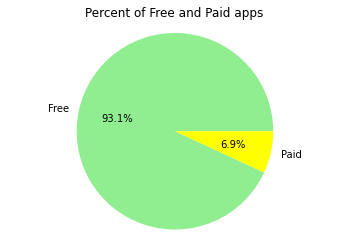

In [16]:
plt.pie(y, labels=x, autopct='%1.1f%%',colors=colors)
plt.title('Percent of Free and Paid apps')
plt.axis('equal')
plt.show()

## Top 10 App Downloaded Categories

In [17]:
sql = '''select c.CategoryName,sum(Installs) as downloads from AppInfo a
inner join Category c
on a.CategoryId = c.id
group by CategoryId
ORDER by downloads DESC
LIMIT 10'''
data = getDataFromDb(sql)
data = random.sample(data, k=len(data))

In [18]:
x = [tup[0] for tup in data]
y = [tup[1] for tup in data]
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(len(y))]

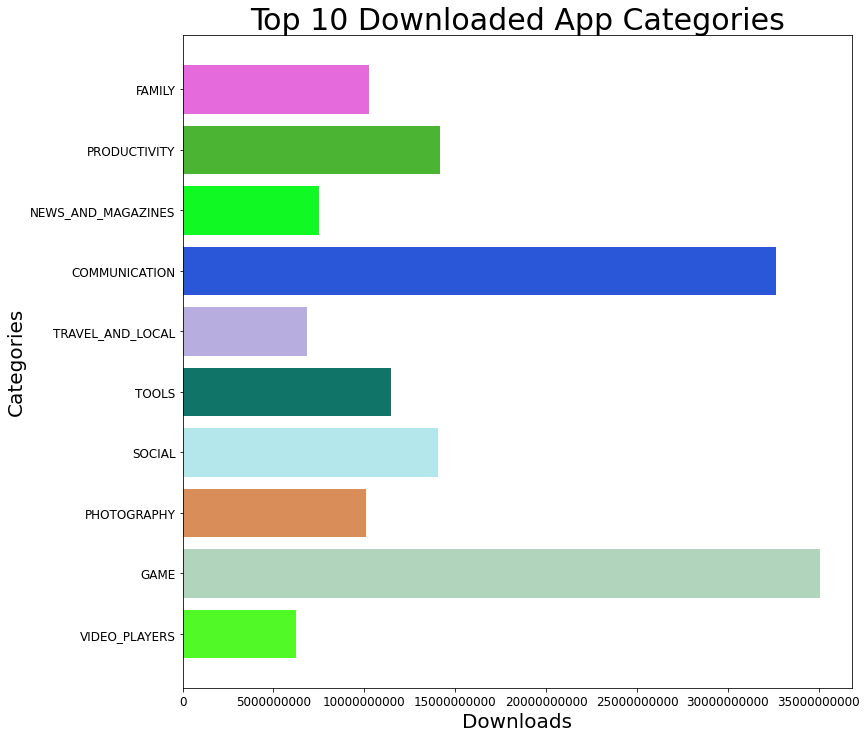

In [19]:
figure(figsize=(12, 12))
plt.barh(x,y,color=color)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Top 10 Downloaded App Categories',fontsize=30)
plt.ylabel('Categories',fontsize=20)
plt.xlabel('Downloads',fontsize=20)
# fig, ax = plt.subplots()
# ax.plot(x, y)
# plt.show()
plt.ticklabel_format( axis='x', style='plain')
plt.show()

## Top 10 Rated Categories

In [20]:
sql = '''select c.CategoryName,avg(Rating) as Reviews from AppInfo a  
left join Category c
on a.CategoryId=c.id
where c.CategoryName in (
	select CategoryName from 
	(	
		select CategoryName,count(a.AppName) as Apps from AppInfo a  
		left join  Category c
		on a.CategoryId=c.id
		group by CategoryName
		order by Apps desc
		limit 10
	)
)
group by CategoryId
order by Reviews
'''
data = getDataFromDb(sql)

In [21]:
x = [tup[0] for tup in data]
y = [tup[1] for tup in data]
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(len(y))]

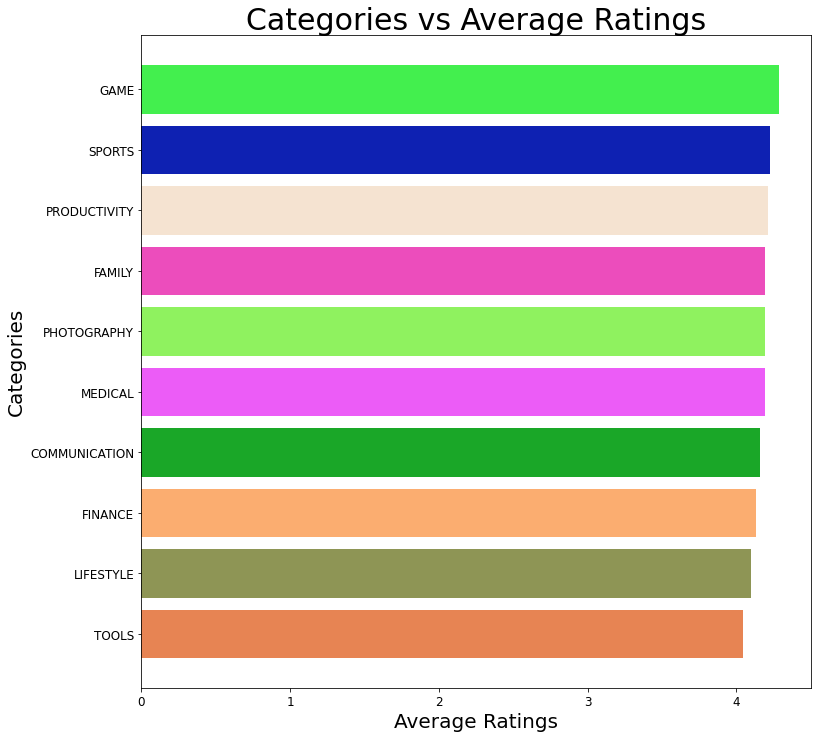

In [22]:
figure(figsize=(12, 12))
plt.barh(x,y,color=color)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Categories vs Average Ratings',fontsize=30)
plt.ylabel('Categories',fontsize=20)
plt.xlabel('Average Ratings',fontsize=20)
# fig, ax = plt.subplots()
# ax.plot(x, y)
# plt.show()
plt.ticklabel_format( axis='x', style='plain')
plt.show()

## Top 10 Genres in Game Category in terms of downloads

In [23]:
sql = '''select GenreName as Genres, sum(Installs) as downloads from AppInfo a  
left join  Genres g
on a.id=g.id
left join Category c 
on c.id = a.CategoryId
where c.CategoryName="GAME"
group by g.GenreName
order by
downloads desc
LIMIT 10
'''
data = getDataFromDb(sql)
data = random.sample(data, k=len(data))

In [24]:
x = [tup[0] for tup in data]
y = [tup[1] for tup in data]
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(len(y))]

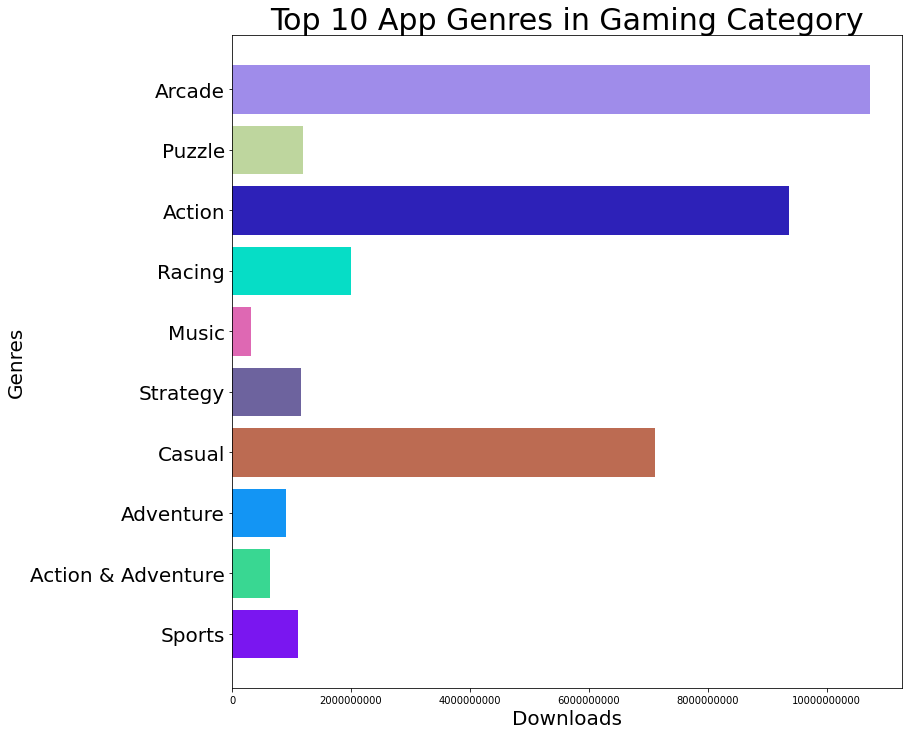

In [25]:
figure(figsize=(12, 12))
plt.barh(x,y,color=color)
plt.yticks(fontsize=20)
plt.title('Top 10 App Genres in Gaming Category',fontsize=30)
plt.ylabel('Genres',fontsize=20)
plt.xlabel('Downloads',fontsize=20)
plt.ticklabel_format( axis='x', style='plain')
plt.show()

## Joint plot Downloads vs Rating

In [26]:
sql = '''select Rating,Installs from AppInfo where Installs>1000'''
data = getDataFromDb(sql)

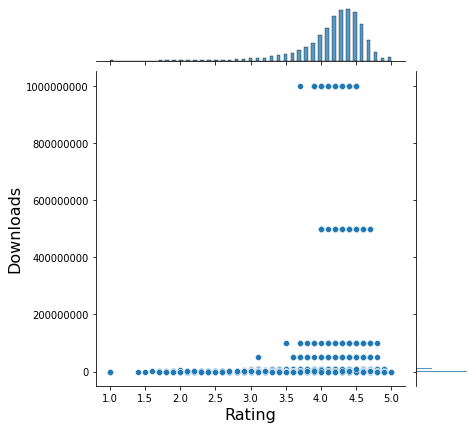

In [31]:
# x, y = np.random.RandomState(8).multivariate_normal([0, 0], [(1, 0), (0, 1)], 1000).T
x = [float(tup[0]) for tup in data]
y = [int(tup[1]) for tup in data]
df = pd.DataFrame({"Rating":x,"Downloads":y})
# sns.ticklabel_format(style='plain', axis='y',useOffset=False)
b = sns.jointplot(data=df,x='Rating', y='Downloads')
b.set_axis_labels('Rating', 'Downloads', fontsize=16)
plt.ticklabel_format( axis='y', style='plain')
plt.show()

## Regression plot Downloads vs Review Count

In [32]:
sql = '''select Installs,Reviews from AppInfo where Installs>1000'''
data = getDataFromDb(sql)

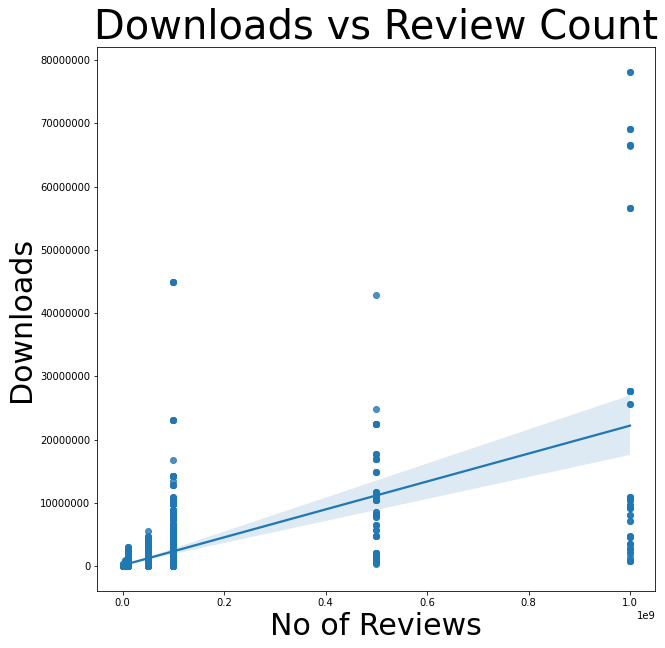

In [33]:
# x, y = np.random.RandomState(8).multivariate_normal([0, 0], [(1, 0), (0, 1)], 1000).T
x = [float(tup[0]) for tup in data]
y = [int(tup[1]) for tup in data]
df = pd.DataFrame({"Installs":x,"Reviews":y})
plt.figure(figsize = (10,10))
# sns.ticklabel_format(style='plain', axis='y',useOffset=False)
b = sns.regplot(data=df,x='Installs', y='Reviews')
b.axes.set_title("Downloads vs Review Count",fontsize=40)
b.set_xlabel("No of Reviews",fontsize=30)
b.set_ylabel("Downloads",fontsize=30)
plt.ticklabel_format( axis='y', style='plain')
plt.show()